# This notebook implements Wasserstein GAN.


In [ ]:
# !pip install -r requirements.txt

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as Dataset
import torchvision.transforms as transforms
import os
import numpy as np

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
manualSeed = np.random.randint(1, 10000) # fix seed
print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)

if not os.path.isdir('visualization'):
   os.mkdir('visualization')
if not os.path.isdir('data'):
   os.mkdir('data')

Random Seed:  6009


In [5]:
im_shape = 64

In [6]:
class Config:
    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

conf = Config(im_shape = 64,
            latent_size = 100,
            in_channels=3,
            out_channels = 16,
            kernel_size = 4,
            n_layers = 5,
            batch_size = 16,
            epochs = 10,
            num_workers=2,
            device='cuda')

In [7]:
# Get dataset from image folder
dataset = Dataset.ImageFolder(root="data/anime",
                        transform=transforms.Compose([
                            transforms.Resize(im_shape),
                            transforms.CenterCrop(im_shape),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))
# loader that handle loading stuff
loader = torch.utils.data.DataLoader(dataset, shuffle=True,#, pin_memory=True,
            batch_size=conf.batch_size, 
            drop_last=True,
            num_workers=conf.num_workers)

In [8]:
class EncoderBlock(nn.Module):
    '''
    Typical CNN network that reduces spacial dimension and increase channels at each step.
    '''
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()

        
        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1, bias=False),
                                nn.BatchNorm2d(out_channels),
                                nn.LeakyReLU(0.3))
        
    def forward(self,x):
        return(self.block(x))

class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        in_channels = config.in_channels
        out_channels = config.out_channels
        kernel_size = config.kernel_size
        n_layers = config.n_layers
        
        self.input = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
                                nn.BatchNorm2d(out_channels),
                                nn.LeakyReLU(0.3))
        self.encode = nn.Sequential(*[EncoderBlock(out_channels*2**i, out_channels*2**(i+1), kernel_size) 
                                    for i in range(0,n_layers-1)])
        self.out = nn.Conv2d(out_channels*(2**(n_layers-1)), 1, 4, 1, 0, bias=False)

    def forward(self,x, y = None):
        x = self.input(x)
        x = self.encode(x)
        x = self.out(x)
        # output a single number for discriminator
        output = x.mean(0)

        return x, output.view(1)


discriminator = Discriminator(conf).to(conf.device)
summary(discriminator,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         LeakyReLU-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 32, 32]           4,608
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
      EncoderBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 16, 16]          18,432
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
     EncoderBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12            [-1, 128, 8, 8]          73,728
      BatchNorm2d-13            [-1, 128, 8, 8]             256
        LeakyReLU-14            [-1, 12

In [9]:
class DecoderBlock(nn.Module):
    '''
    Reverse of Encoder
    '''
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.block = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU())

        
    def forward(self,x):
        return(self.block(x))
        
class Generator(nn.Module):
    def __init__(self, config):
        super().__init__()
        in_channels = config.in_channels
        out_channels = config.out_channels
        kernel_size = config.kernel_size
        n_layers = config.n_layers
        latent_size = config.latent_size

        self.input = nn.Sequential(nn.ConvTranspose2d(latent_size, out_channels*(2**(n_layers-1)), 4, stride=1, bias=False),
                                nn.BatchNorm2d(out_channels*(2**(n_layers-1))),
                                nn.ReLU())
                    
        self.decode = nn.Sequential(*[DecoderBlock(out_channels*2**(i+1), out_channels*2**i, kernel_size) 
                                    for i in range(n_layers-2,-1,-1)])
        
        self.out = nn.Sequential(nn.Conv2d(out_channels, in_channels, 1, 
                                stride=1, padding=0, bias=False))

        
        self.out_channels = out_channels
        self.n_layers = n_layers
        self.im_shape = config.im_shape

    def forward(self,x):
        x = self.input(x)
        
        x = self.decode(x)
        x = torch.tanh(self.out(x))
        
        return x


generator = Generator(conf).to(conf.device)
summary(generator,(100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
      DecoderBlock-7            [-1, 128, 8, 8]               0
   ConvTranspose2d-8           [-1, 64, 16, 16]         131,072
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
     DecoderBlock-11           [-1, 64, 16, 16]               0
  ConvTranspose2d-12           [-1, 32, 32, 32]          32,768
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

In [10]:
def show_progress(x, it):
    '''
    Display and save visualization
    '''
    discriminator.eval()
    with torch.no_grad():
        num_vis = min(conf.batch_size, 8)
        x = x[0:num_vis]
        x = x.cpu().numpy()
        
        plt.figure(figsize=(num_vis*3, 7))
        for i, obj_plot in enumerate(x):
            
            obj_plot = np.moveaxis(obj_plot, 0, -1)
            plt.subplot(1, num_vis, i+1)
            plt.imshow(obj_plot*0.5 +0.5)
            plt.axis('off')

    plt.savefig('visualization/'+ str(it)+'.jpg', format='jpg', bbox_inches='tight')
    plt.show()
    discriminator.train()

In [11]:
device = conf.device
netD = Discriminator(conf).to(device)
netG = Generator(conf).to(device)


optimizerG = torch.optim.RMSprop(netG.parameters(), lr=0.00005)
optimizerD = torch.optim.RMSprop(netD.parameters(), lr=0.00005)

fixed_noise = torch.randn(conf.batch_size, 100, 1, 1).to(device)

loss_D = []
loss_G = []
loss_D_smooth = 0
loss_G_smooth = 0
gen_iterations = 0
pbar = tqdm(total=len(loader))

  0%|          | 0/3972 [00:00<?, ?it/s]

  0%|          | 0/3972 [00:00<?, ?it/s]
epoch 0 | 0 | netD -0.05446 | netG 0.02622 | D_real -0.28776 | D_fake 0.25689:   3%|▎         | 100/3972 [00:02<00:51, 74.92it/s]

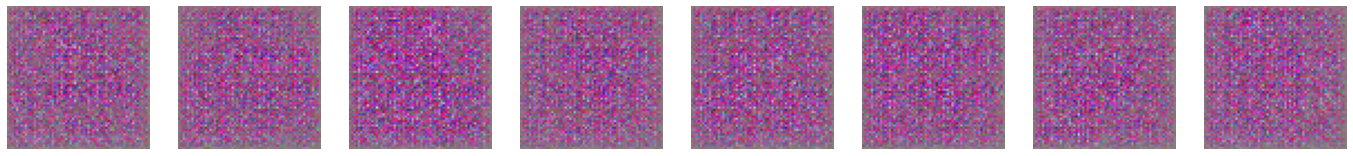

epoch 0 | 500 | netD -0.70529 | netG 0.34599 | D_real -0.35605 | D_fake 0.34604:  89%|████████▉ | 3550/3972 [00:51<00:05, 83.86it/s]

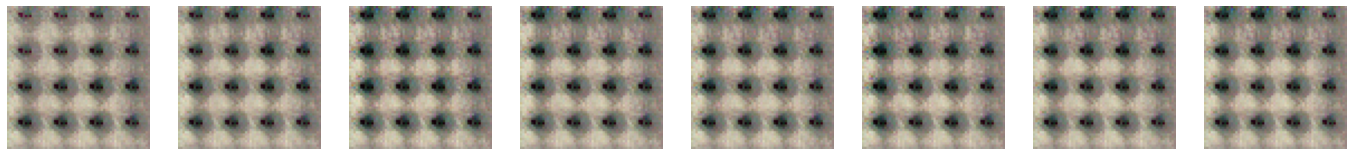

epoch 0 | 585 | netD -0.70160 | netG 0.33255 | D_real -0.33145 | D_fake 0.34231: 100%|██████████| 3972/3972 [00:58<00:00, 68.15it/s]
epoch 1 | 1000 | netD -0.61415 | netG 0.31166 | D_real -0.35531 | D_fake 0.27036:  55%|█████▍    | 2170/3972 [00:33<00:21, 82.51it/s]

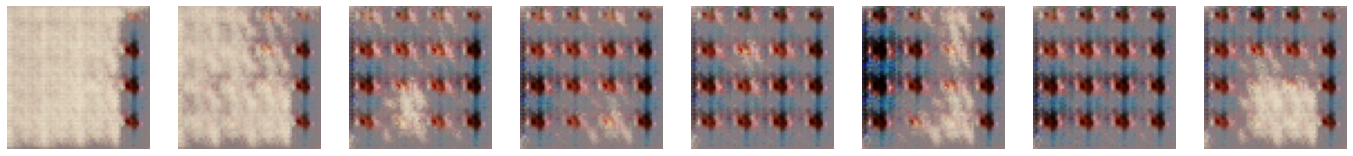

epoch 1 | 1361 | netD -0.62296 | netG 0.31170 | D_real -0.34929 | D_fake 0.33644: 100%|██████████| 3972/3972 [00:59<00:00, 66.35it/s]
epoch 2 | 1500 | netD -0.59865 | netG 0.27960 | D_real -0.31867 | D_fake 0.33384:  20%|█▉        | 790/3972 [00:12<00:38, 83.37it/s]

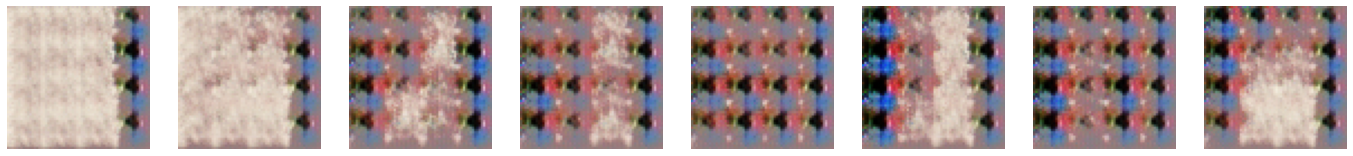

epoch 2 | 1772 | netD -0.60120 | netG 0.30538 | D_real -0.32683 | D_fake 0.31847:  54%|█████▍    | 2150/3972 [00:33<00:27, 66.84it/s]

KeyboardInterrupt: 

epoch 2 | 1772 | netD -0.60120 | netG 0.30538 | D_real -0.32683 | D_fake 0.31847:  54%|█████▍    | 2155/3972 [00:51<00:27, 66.84it/s]

In [12]:
for epoch in range(conf.epochs):
    pbar.close() # close for each run
    pbar = tqdm(total=len(loader))
    data_iter = iter(loader)
    i = 0
    while i < len(loader):
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update

        # train the discriminator Diters times
        if gen_iterations < 10 or gen_iterations % 500 == 0:
            Diters = 100
        else:
            Diters = 5
        j = 0
        while j < Diters and i < len(loader):
            j += 1

            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(-0.01, 0.01)

            x_real = data_iter.next()[0].to(device)
            i += 1
            pbar.update(1)

            netD.zero_grad()
            score, errD_real = netD(x_real)

            # noise that we will feed into netG
            noise = torch.randn(conf.batch_size, 100, 1, 1).to(device)
            with torch.no_grad():
                x_fake = netG(noise)
            score, errD_fake = netD(x_fake)

            # Earth Mover loss to udpate netD
            errD = errD_real - errD_fake
            errD.backward()
            optimizerD.step()
        loss_D_smooth = 0.9*loss_D_smooth + 0.1*errD.item()
        loss_D.append(loss_D_smooth)
        
        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        
        netG.zero_grad()
        noise = torch.randn(conf.batch_size, 100, 1, 1).to(device)
        x_fake = netG(noise)

        # update netG
        score, errG = netD(x_fake)
        errG.backward()
        optimizerG.step()
        loss_G_smooth = 0.9*loss_G_smooth + 0.1*errG.item()
        loss_G.append(loss_G_smooth)
        
        pbar.set_description(f"epoch {epoch} | {gen_iterations} | netD {loss_D_smooth:.5f} | netG {loss_G_smooth:.5f} | D_real {errD_real.item():.5f} | D_fake {errD_fake.item():.5f}")
        if gen_iterations % 500 == 0:
            with torch.no_grad():
                x_fake = netG(fixed_noise)
            show_progress(x_fake, gen_iterations)

        gen_iterations += 1



In [ ]:
plt.figure()
plt.plot(range(len(loss_D)), loss_D)
plt.plot(range(len(loss_G)), loss_G)
plt.legend(['discriminator loss', 'generator loss'])
plt.show()